# v8 Training: Cross-Lingual Neural Sparse Model

이 노트북에서는 클러스터링으로 생성된 동의어 데이터셋을 사용하여 v8 모델을 학습합니다.

## v8 특징
- **한국어 + 영어 토큰 동시 활성화**: 입력 한국어 토큰 보존 + 영어 동의어 활성화
- **클러스터 기반 동의어**: E5 임베딩 + K-means로 생성된 동의어 셋 사용
- **Self-Preservation Loss**: 입력 토큰 보존을 위한 추가 손실 함수

## 1. Setup

In [39]:
import sys
import json
from pathlib import Path

def find_project_root():
    candidates = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train"),
    ]
    for candidate in candidates:
        if (candidate / "CLAUDE.md").exists() or (candidate / ".git").exists():
            return candidate
    return Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train")

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import pandas as pd

from src.model.splade_model import create_splade_model

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch: 2.10.0.dev20251109+cu130
CUDA available: True
Using device: cuda


## 2. Configuration

In [41]:
# Training configuration
CONFIG = {
    # Model
    'model_name': 'bert-base-multilingual-cased',
    'max_length': 64,
    
    # Data
    'data_path': PROJECT_ROOT / 'dataset' / 'v8_clustered' / 'synonym_clusters.jsonl',
    
    # Training
    'batch_size': 64,
    'num_epochs': 3,  # Start with 3 epochs
    'learning_rate': 2e-5,
    'warmup_ratio': 0.1,
    'max_grad_norm': 1.0,
    
    # Loss weights
    'lambda_self': 1.0,      # Self-preservation (Korean tokens)
    'lambda_target': 1.0,    # English target tokens
    'lambda_synonym': 0.5,   # Synonym tokens (both KO and EN)
    'lambda_margin': 0.3,    # Margin loss
    'lambda_sparsity': 0.01, # Sparsity regularization
    
    # Margin
    'target_margin': 0.5,
    
    # Output
    'output_dir': PROJECT_ROOT / 'outputs' / 'v8_cross_lingual',
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  model_name: bert-base-multilingual-cased
  max_length: 64
  data_path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/synonym_clusters.jsonl
  batch_size: 64
  num_epochs: 3
  learning_rate: 2e-05
  warmup_ratio: 0.1
  max_grad_norm: 1.0
  lambda_self: 1.0
  lambda_target: 1.0
  lambda_synonym: 0.5
  lambda_margin: 0.3
  lambda_sparsity: 0.01
  target_margin: 0.5
  output_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v8_cross_lingual


## 3. Load Dataset

In [42]:
# Check if dataset exists
if not CONFIG['data_path'].exists():
    print(f"Dataset not found at {CONFIG['data_path']}")
    print("Please run 01_data_preparation_clustering.ipynb first!")
else:
    print(f"Dataset found: {CONFIG['data_path']}")

Dataset found: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/synonym_clusters.jsonl


In [43]:
class SynonymClusterDataset(Dataset):
    """
    Dataset for v8 training with synonym clusters.
    Each sample has Korean term, English term, and synonyms.
    """
    
    def __init__(self, data_path: Path, tokenizer, max_length: int = 64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        
        print(f"Loading dataset from {data_path}...")
        
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                item = json.loads(line.strip())
                
                # Get token IDs for targets
                ko_term = item['ko_term']
                en_term = item['en_term']
                
                # Tokenize Korean term (for self-preservation)
                ko_tokens = tokenizer.tokenize(ko_term)
                ko_token_ids = tokenizer.convert_tokens_to_ids(ko_tokens)
                ko_token_ids = [tid for tid in ko_token_ids if tid != tokenizer.unk_token_id]
                
                # Tokenize English term (for cross-lingual activation)
                en_tokens = tokenizer.tokenize(en_term.lower())
                en_token_ids = tokenizer.convert_tokens_to_ids(en_tokens)
                en_token_ids = [tid for tid in en_token_ids if tid != tokenizer.unk_token_id]
                
                # Tokenize synonyms
                ko_syn_ids = []
                for syn in item.get('ko_synonyms', []):
                    syn_tokens = tokenizer.tokenize(syn)
                    syn_ids = tokenizer.convert_tokens_to_ids(syn_tokens)
                    ko_syn_ids.extend([tid for tid in syn_ids if tid != tokenizer.unk_token_id])
                
                en_syn_ids = []
                for syn in item.get('en_synonyms', []):
                    syn_tokens = tokenizer.tokenize(syn.lower())
                    syn_ids = tokenizer.convert_tokens_to_ids(syn_tokens)
                    en_syn_ids.extend([tid for tid in syn_ids if tid != tokenizer.unk_token_id])
                
                if ko_token_ids and en_token_ids:
                    self.data.append({
                        'ko_term': ko_term,
                        'en_term': en_term,
                        'ko_token_ids': ko_token_ids,
                        'en_token_ids': en_token_ids,
                        'ko_syn_ids': list(set(ko_syn_ids))[:10],  # Dedupe and limit
                        'en_syn_ids': list(set(en_syn_ids))[:10],
                    })
        
        print(f"Loaded {len(self.data)} samples")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Encode Korean term as input
        encoding = self.tokenizer(
            item['ko_term'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'ko_token_ids': item['ko_token_ids'],
            'en_token_ids': item['en_token_ids'],
            'ko_syn_ids': item['ko_syn_ids'],
            'en_syn_ids': item['en_syn_ids'],
        }

In [44]:
def collate_fn(batch):
    """Custom collate function for variable-length token ID lists."""
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'ko_token_ids': [item['ko_token_ids'] for item in batch],
        'en_token_ids': [item['en_token_ids'] for item in batch],
        'ko_syn_ids': [item['ko_syn_ids'] for item in batch],
        'en_syn_ids': [item['en_syn_ids'] for item in batch],
    }

In [45]:
# Load tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

dataset = SynonymClusterDataset(
    CONFIG['data_path'],
    tokenizer,
    CONFIG['max_length']
)

dataloader = DataLoader(
    dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
    pin_memory=True
)

print(f"Dataset size: {len(dataset):,}")
print(f"Batches per epoch: {len(dataloader):,}")

Loading dataset from /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/synonym_clusters.jsonl...
Loaded 10 samples
Dataset size: 10
Batches per epoch: 1


## 4. Loss Functions

In [46]:
class V8CrossLingualLoss(nn.Module):
    """
    v8 Loss: Self-Preservation + Cross-Lingual Target + Synonym Activation
    
    Goals:
    1. Preserve Korean input tokens (self-preservation)
    2. Activate English translation tokens (cross-lingual)
    3. Activate synonym tokens (both KO and EN)
    """
    
    def __init__(self, target_margin: float = 0.5):
        super().__init__()
        self.target_margin = target_margin
    
    def forward(
        self,
        sparse_rep: torch.Tensor,
        ko_token_ids: list,
        en_token_ids: list,
        ko_syn_ids: list,
        en_syn_ids: list,
    ) -> dict:
        """
        Compute all loss components.
        
        Returns dict with individual losses.
        """
        batch_size = sparse_rep.shape[0]
        device = sparse_rep.device
        
        self_loss = torch.tensor(0.0, device=device)
        target_loss = torch.tensor(0.0, device=device)
        synonym_loss = torch.tensor(0.0, device=device)
        margin_loss = torch.tensor(0.0, device=device)
        
        n_valid = 0
        
        for i in range(batch_size):
            rep = sparse_rep[i]
            
            # 1. Self-preservation loss (Korean tokens)
            if ko_token_ids[i]:
                ko_ids = torch.tensor(ko_token_ids[i], device=device)
                ko_activations = rep[ko_ids]
                self_loss = self_loss - torch.log(ko_activations + 1e-8).mean()
            
            # 2. English target loss
            if en_token_ids[i]:
                en_ids = torch.tensor(en_token_ids[i], device=device)
                en_activations = rep[en_ids]
                target_loss = target_loss - torch.log(en_activations + 1e-8).mean()
                
                # Margin loss for English tokens
                margin_loss = margin_loss + F.relu(self.target_margin - en_activations).mean()
            
            # 3. Synonym loss (both KO and EN synonyms)
            all_syn_ids = ko_syn_ids[i] + en_syn_ids[i]
            if all_syn_ids:
                syn_ids = torch.tensor(all_syn_ids, device=device)
                syn_activations = rep[syn_ids]
                synonym_loss = synonym_loss - torch.log(syn_activations + 1e-8).mean()
            
            n_valid += 1
        
        if n_valid > 0:
            self_loss = self_loss / n_valid
            target_loss = target_loss / n_valid
            synonym_loss = synonym_loss / n_valid
            margin_loss = margin_loss / n_valid
        
        return {
            'self': self_loss,
            'target': target_loss,
            'synonym': synonym_loss,
            'margin': margin_loss,
        }

## 5. Model and Training Setup

In [47]:
# Create model
model = create_splade_model(
    model_name=CONFIG['model_name'],
    use_idf=False,
    use_expansion=True,
    expansion_mode='mlm',
)
model = model.to(device)

print(f"Model created: {CONFIG['model_name']}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model created: bert-base-multilingual-cased
Total parameters: 177,974,523


In [48]:
# Loss function
loss_fn = V8CrossLingualLoss(target_margin=CONFIG['target_margin'])

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=0.01
)

# Scheduler
total_steps = len(dataloader) * CONFIG['num_epochs']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Total steps: {total_steps:,}")
print(f"Warmup steps: {warmup_steps:,}")

Total steps: 3
Warmup steps: 0


## 6. Evaluation Function

In [49]:
TEST_PAIRS = [
    ("머신러닝", ["machine", "learning"], ["머신", "러닝"]),
    ("딥러닝", ["deep", "learning"], ["딥", "러닝"]),
    ("데이터", ["data"], ["데이터"]),
    ("컴퓨터", ["computer"], ["컴퓨터"]),
    ("네트워크", ["network"], ["네트워크"]),
]

def evaluate_model(model, tokenizer, device, top_k=50):
    """
    Evaluate model on test pairs.
    Check both Korean self-preservation and English activation.
    """
    model.eval()
    
    results = []
    ko_activated_total = 0
    en_activated_total = 0
    ko_expected_total = 0
    en_expected_total = 0
    
    with torch.no_grad():
        for ko_term, en_expected, ko_expected in TEST_PAIRS:
            encoding = tokenizer(
                ko_term,
                max_length=64,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            sparse_rep, _ = model(
                encoding['input_ids'].to(device),
                encoding['attention_mask'].to(device)
            )
            
            sparse_rep = sparse_rep[0].cpu()
            top_indices = torch.topk(sparse_rep, k=top_k).indices.tolist()
            top_tokens = set(tokenizer.convert_ids_to_tokens(top_indices))
            
            # Check Korean preservation
            ko_activated = []
            for ko in ko_expected:
                ko_toks = tokenizer.tokenize(ko)
                for tok in ko_toks:
                    ko_expected_total += 1
                    if tok in top_tokens:
                        ko_activated_total += 1
                        ko_activated.append(tok)
            
            # Check English activation
            en_activated = []
            for en in en_expected:
                en_toks = tokenizer.tokenize(en.lower())
                for tok in en_toks:
                    en_expected_total += 1
                    if tok in top_tokens:
                        en_activated_total += 1
                        en_activated.append(tok)
            
            results.append({
                'input': ko_term,
                'ko_activated': ko_activated,
                'en_activated': en_activated,
                'top_5': list(top_tokens)[:5]
            })
    
    model.train()
    
    ko_rate = ko_activated_total / ko_expected_total * 100 if ko_expected_total > 0 else 0
    en_rate = en_activated_total / en_expected_total * 100 if en_expected_total > 0 else 0
    
    return {
        'ko_rate': ko_rate,
        'en_rate': en_rate,
        'details': results
    }

In [50]:
# Initial evaluation
print("Initial evaluation (before training):")
init_eval = evaluate_model(model, tokenizer, device)
print(f"  Korean preservation rate: {init_eval['ko_rate']:.1f}%")
print(f"  English activation rate: {init_eval['en_rate']:.1f}%")

Initial evaluation (before training):
  Korean preservation rate: 100.0%
  English activation rate: 0.0%


## 7. Training Loop

In [51]:
# Create output directory
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)

# Training history
history = []

print("=" * 70)
print(f"STARTING TRAINING (v8)")
print(f"Epochs: {CONFIG['num_epochs']}")
print("=" * 70)

STARTING TRAINING (v8)
Epochs: 3


In [52]:
for epoch in range(CONFIG['num_epochs']):
    print(f"\n--- Epoch {epoch + 1}/{CONFIG['num_epochs']} ---")
    model.train()
    
    epoch_losses = {
        'total': 0.0,
        'self': 0.0,
        'target': 0.0,
        'synonym': 0.0,
        'margin': 0.0,
        'sparsity': 0.0,
    }
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
    
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Forward pass
        sparse_rep, _ = model(input_ids, attention_mask)
        
        # Compute losses
        losses = loss_fn(
            sparse_rep,
            batch['ko_token_ids'],
            batch['en_token_ids'],
            batch['ko_syn_ids'],
            batch['en_syn_ids'],
        )
        
        # Sparsity loss
        sparsity_loss = sparse_rep.mean()
        
        # Total loss
        total_loss = (
            CONFIG['lambda_self'] * losses['self'] +
            CONFIG['lambda_target'] * losses['target'] +
            CONFIG['lambda_synonym'] * losses['synonym'] +
            CONFIG['lambda_margin'] * losses['margin'] +
            CONFIG['lambda_sparsity'] * sparsity_loss
        )
        
        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # Accumulate losses
        epoch_losses['total'] += total_loss.item()
        epoch_losses['self'] += losses['self'].item()
        epoch_losses['target'] += losses['target'].item()
        epoch_losses['synonym'] += losses['synonym'].item()
        epoch_losses['margin'] += losses['margin'].item()
        epoch_losses['sparsity'] += sparsity_loss.item()
        
        # Update progress bar
        if (batch_idx + 1) % 100 == 0:
            progress_bar.set_postfix({
                'loss': f"{epoch_losses['total'] / (batch_idx + 1):.4f}",
                'self': f"{epoch_losses['self'] / (batch_idx + 1):.4f}",
                'tgt': f"{epoch_losses['target'] / (batch_idx + 1):.4f}",
            })
    
    # Average losses
    n_batches = len(dataloader)
    for key in epoch_losses:
        epoch_losses[key] /= n_batches
    
    history.append(epoch_losses)
    
    # Evaluate
    eval_result = evaluate_model(model, tokenizer, device)
    
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Total Loss: {epoch_losses['total']:.4f}")
    print(f"  Self Loss: {epoch_losses['self']:.4f}")
    print(f"  Target Loss: {epoch_losses['target']:.4f}")
    print(f"  Synonym Loss: {epoch_losses['synonym']:.4f}")
    print(f"  Korean Preservation: {eval_result['ko_rate']:.1f}%")
    print(f"  English Activation: {eval_result['en_rate']:.1f}%")
    
    # Save checkpoint
    checkpoint_path = CONFIG['output_dir'] / f'checkpoint_epoch{epoch + 1}.pt'
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': epoch_losses,
        'eval': eval_result,
    }, checkpoint_path)
    print(f"  Saved: {checkpoint_path}")


--- Epoch 1/3 ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 1 Summary:
  Total Loss: 0.0644
  Self Loss: -1.0952
  Target Loss: 0.8199
  Synonym Loss: 0.6538
  Korean Preservation: 93.3%
  English Activation: 14.3%
  Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v8_cross_lingual/checkpoint_epoch1.pt

--- Epoch 2/3 ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 2 Summary:
  Total Loss: -1.8346
  Self Loss: -1.1317
  Target Loss: -0.5924
  Synonym Loss: -0.2307
  Korean Preservation: 100.0%
  English Activation: 28.6%
  Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v8_cross_lingual/checkpoint_epoch2.pt

--- Epoch 3/3 ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 3 Summary:
  Total Loss: -2.3413
  Self Loss: -1.1619
  Target Loss: -0.8659
  Synonym Loss: -0.6372
  Korean Preservation: 100.0%
  English Activation: 28.6%


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call

  Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v8_cross_lingual/checkpoint_epoch3.pt


## 8. Save Final Model

In [53]:
# Save final model
final_path = CONFIG['output_dir'] / 'final_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()},
    'history': history,
}, final_path)

print(f"Final model saved: {final_path}")

Final model saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v8_cross_lingual/final_model.pt


In [54]:
# Save training history
with open(CONFIG['output_dir'] / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print("Training history saved")

Training history saved


## 9. Final Evaluation

In [55]:
# Final evaluation
print("\n" + "=" * 70)
print("FINAL EVALUATION")
print("=" * 70)

final_eval = evaluate_model(model, tokenizer, device)

print(f"\nKorean Preservation Rate: {final_eval['ko_rate']:.1f}%")
print(f"English Activation Rate: {final_eval['en_rate']:.1f}%")

print("\nDetailed Results:")
for result in final_eval['details']:
    print(f"\n  Input: {result['input']}")
    print(f"    Korean activated: {result['ko_activated']}")
    print(f"    English activated: {result['en_activated']}")
    print(f"    Top-5: {result['top_5']}")


FINAL EVALUATION

Korean Preservation Rate: 100.0%
English Activation Rate: 28.6%

Detailed Results:

  Input: 머신러닝
    Korean activated: ['머신', '러', '##닝']
    English activated: ['machine']
    Top-5: ['##ラ', '##ニング', '러', '裡', 'ή']

  Input: 딥러닝
    Korean activated: ['딥', '러', '##닝']
    English activated: []
    Top-5: ['##ニング', '러', '##υ', '##로', '##런']

  Input: 데이터
    Korean activated: ['데', '##이터']
    English activated: []
    Top-5: ['-', '軟', '指', 'de', 'да']

  Input: 컴퓨터
    Korean activated: ['컴', '##퓨', '##터']
    English activated: []
    Top-5: ['комп', 'математик', '宇', '-', 'Apple']

  Input: 네트워크
    Korean activated: ['네', '##트', '##워', '##크']
    English activated: ['network']
    Top-5: ['##t', '##ス', '##ント', 'ネ', '##ок']


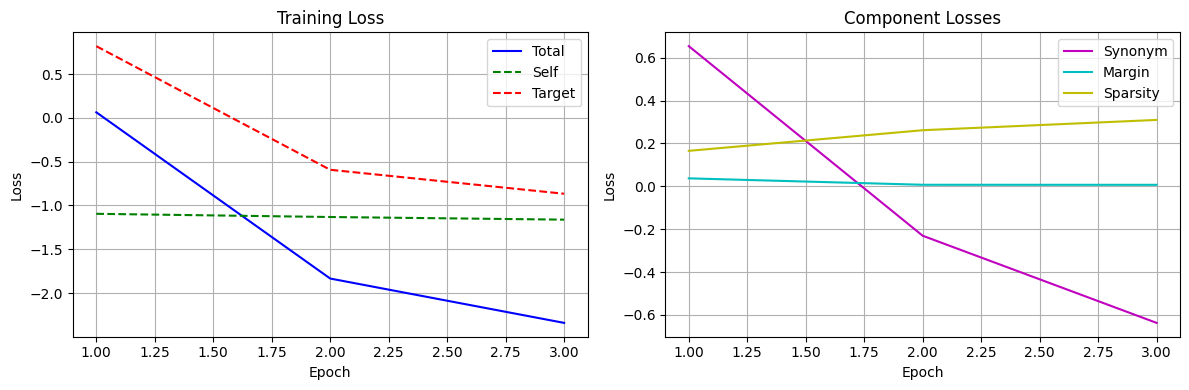

In [56]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = range(1, len(history) + 1)

# Loss plot
axes[0].plot(epochs, [h['total'] for h in history], 'b-', label='Total')
axes[0].plot(epochs, [h['self'] for h in history], 'g--', label='Self')
axes[0].plot(epochs, [h['target'] for h in history], 'r--', label='Target')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

# Component losses
axes[1].plot(epochs, [h['synonym'] for h in history], 'm-', label='Synonym')
axes[1].plot(epochs, [h['margin'] for h in history], 'c-', label='Margin')
axes[1].plot(epochs, [h['sparsity'] for h in history], 'y-', label='Sparsity')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Component Losses')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(CONFIG['output_dir'] / 'training_curves.png', dpi=150)
plt.show()

## 10. Summary

In [57]:
print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)
print(f"\nModel: {CONFIG['model_name']}")
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Dataset size: {len(dataset):,}")
print(f"\nFinal Results:")
print(f"  Korean Preservation: {final_eval['ko_rate']:.1f}%")
print(f"  English Activation: {final_eval['en_rate']:.1f}%")
print(f"\nOutput directory: {CONFIG['output_dir']}")


TRAINING COMPLETE

Model: bert-base-multilingual-cased
Epochs: 3
Dataset size: 10

Final Results:
  Korean Preservation: 100.0%
  English Activation: 28.6%

Output directory: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v8_cross_lingual
